In [1]:
################################################################################                                                                                                                                                              
################################################################################
#
# FILE: match.ipynb
#
# BY: Dmitry Sedov 
#
# CREATED: Wed Feb 5 2020
#
# DESC: This file contains the code that creates a matching between
# sname_place_id and Yelp id based on:
#       1) geographical proximity
#       2) phone number Fusion API search
#       3) street address Fusion APi search
#       4) name similarity
#
# EXEC: 
#      
################################################################################
################################################################################

In [2]:
# Module that executes the PostgreSQL geo-matching statements
sg_yelp_geo_matching = __import__('sname-yelp-geo-matching')
# PostgreSQL library
import psycopg2
# Reimport library
import importlib
# Database interaction library
import sqlalchemy as db
# Logging library 
import logging 
logging.basicConfig(level=logging.INFO)
# Print-functions-code library
import inspect
# Plottng library
from matplotlib import pyplot as plt
%matplotlib inline
# Numpy 
import numpy as np
# Pandas
import pandas as pd

In [3]:
engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname1}')
connection = engine.connect()

In [4]:
# Create potential matches based on geographical proximity
match_distance_candidates = sg_yelp_geo_matching.match_candidates_by_distance(connection)

INFO:root:Creating restaurants table.
INFO:root:Restaurants table created.
INFO:root:Creating Yelp copy.
INFO:root:Yelp copy created.
INFO:root:Doing the spatial join.
INFO:root:Spatial join completed.


In [5]:
# Create potential matches based on the phone number search
create_yelp_phone_copy_statement = """
CREATE TEMPORARY TABLE yelp_phone_copy AS (                                                                            
    SELECT                                                                                                             
        *,
        location::geography AS location_geography                                                                      
    FROM
        more_yelp_restaurants                                                                                          
);                                                                                                                     

CREATE INDEX yelp_phone_copy_location_geography_idx                                                                    
ON yelp_phone_copy
USING GIST (location_geography);                                                                                       
"""                                                                                                                    

sname_yelp_phone_join_statement = """
CREATE TEMPORARY TABLE match_phone_candidates AS (                                                                     
    SELECT
        r.sname_place_id,
        r.location_name AS r_location_name,                                                                            
        r.zip_code AS r_zip_code,                                                                                      
        r.city AS r_city,
        r.state AS r_state,
        r.street_address AS r_street_address,                                                                          
        r.phone_number AS r_phone_number,                                                                              
        y.id AS y_id,
        y.name AS y_name,
        y.phone AS y_phone,
        y.zip_code AS y_zip_code,                                                                                      
        y.address1 AS y_address1,
        ST_Distance(r.location, y.location_geography) AS distance                                                      
    FROM
        restaurants AS r                                                                                               
    LEFT JOIN
        yelp_phone_copy AS y                                                                                           
    ON 
        r.sname_place_id = y.sname_place_id
    ORDER BY 
        r.sname_place_id,                                                                                          
        distance                                                                                                       
);
"""
connection.execute(create_yelp_phone_copy_statement) 
connection.execute(sname_yelp_phone_join_statement)
match_phone_candidates = pd.read_sql_query('SELECT * FROM match_phone_candidates WHERE distance <= 300', 
                                           con = connection) 

In [6]:
# Create potential matches based on the address search
create_yelp_address_copy_statement = """
CREATE TEMPORARY TABLE yelp_address_copy AS (                                                                            
    SELECT                                                                                                             
        *,
        location::geography AS location_geography                                                                      
    FROM
        address_yelp_restaurants                                                                                          
);                                                                                                                     

CREATE INDEX yelp_address_copy_location_geography_idx                                                                    
ON yelp_address_copy
USING GIST (location_geography);                                                                                       
"""                                                                                                                    

sname_yelp_address_join_statement = """
CREATE TEMPORARY TABLE match_address_candidates AS (                                                                     
    SELECT
        r.sname_place_id,
        r.location_name AS r_location_name,                                                                            
        r.zip_code AS r_zip_code,                                                                                      
        r.city AS r_city,
        r.state AS r_state,
        r.street_address AS r_street_address,                                                                          
        r.phone_number AS r_phone_number,                                                                              
        y.id AS y_id,
        y.name AS y_name,
        y.phone AS y_phone,
        y.zip_code AS y_zip_code,                                                                                      
        y.address1 AS y_address1,
        ST_Distance(r.location, y.location_geography) AS distance                                                      
    FROM
        restaurants AS r                                                                                               
    LEFT JOIN
        yelp_address_copy AS y                                                                                           
    ON 
        r.sname_place_id = y.sname_place_id
    ORDER BY 
        r.sname_place_id,                                                                                          
        distance                                                                                                       
);
"""
connection.execute(create_yelp_address_copy_statement) 
connection.execute(sname_yelp_address_join_statement)
match_address_candidates = pd.read_sql_query('SELECT * FROM match_address_candidates WHERE distance <= 300', 
                                           con = connection) 

In [8]:
match_distance_candidates.head()

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance
0,sg:0000151bf1ed4fe3a39f1b27327821bf,New Ocean Chinese Restaurant,93458,santa maria,ca,331 town center west,+18059251500,Z19kDppC2EAzT3s31mYtIA,New Ocean Chinese Restaurant,+18059251500,93458,331 Town Ctr W,1.616780
1,sg:0000151bf1ed4fe3a39f1b27327821bf,New Ocean Chinese Restaurant,93458,santa maria,ca,331 town center west,+18059251500,yIsF76sDCDabLbBNq_J9Dw,Nacho's Mexican Restaurant,+18059251891,93454,209 Town Ctr E,98.281753
2,sg:00001b8625b64052888b8c2f2e3736bb,Golden Corral,32819,orlando,fl,8032 international drive,+14073526606,Tm_28r-suhH8dUkjRoMjAA,Golden Corral Buffet & Grill,+14073526606,32819,8032 International Drive,2.523560
3,sg:00001b8625b64052888b8c2f2e3736bb,Golden Corral,32819,orlando,fl,8032 international drive,+14073526606,TXLHsexRp-ijxlnL5bu_ig,Cold Stone Creamery,+14072242295,32819,1000 Universal Studios Plaza,68.635658
4,sg:0000342b96c3453fbcd3c80308517f75,Pizza Hut,32348,perry,fl,2199 south byron butler parkway,+18505847480,pYrHAeko8pAwWyxn0Hgltw,Pizza Hut,+18505847480,32347,2199 S Byron Butler Pkwy,3.335255


In [9]:
match_phone_candidates.head()

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance
0,sg:00001b8625b64052888b8c2f2e3736bb,Golden Corral,32819,orlando,fl,8032 international drive,+14073526606,Tm_28r-suhH8dUkjRoMjAA,Golden Corral Buffet & Grill,+14073526606,32819,8032 International Drive,2.523560
1,sg:00003e1625674e2f812a9d8d6e992058,Schmizza,97232,portland,or,628 north east broadway street,+15035179981,WMUCB1_ZDBmvZ5inptTCjg,Pizza Schmizza Pub & Grub,+15035179981,97232,628 NE Broadway St,9.545163
2,sg:0000b846c3a14858991896452c6db6be,Popeyes Louisiana Kitchen,29209,columbia,sc,7540 garners ferry road,+18037769633,Znn-iqQfi9AMXbKaA2xdGg,Popeyes Louisiana Kitchen,+18037769633,29209,7540 Garners Ferry Rd,2.464139
3,sg:0000cb70fb14407eb09e258033ed2f0b,Pick Up Stix,92029,escondido,ca,1284 auto park way,+17604898533,wABs0V1sTZd4IEzZfWk8GA,Pick Up Stix,+17604898533,92029,1284 Auto Pkwy,13.821985
4,sg:0000d1c2461c418d86abec03a7a8c59a,Malri Hyang,98003,federal way,wa,31217 pacific highway south,+12539460848,UCKHou4x8jkWXvvrkP_VaQ,Malri Hyang,+12539460848,98003,31217 Pacific Hwy S,43.917211


In [10]:
match_address_candidates.head()

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance
0,sg:000184ebd4da44569dc68a98ed4d500b,Hibachi Grill,46037,fishers,in,8938 east 96th street,None,JvvOh9kS2bsegnCVdtf0yQ,Hibachi Grill,,46037,8938 E 96th St,14.993762
1,sg:000217a1bb9041aaa50d69d7f09be8af,Chicken Charlie's At La County Fair,91768,pomona,ca,1101 west mckinley avenue,None,Jw3752HkxkzEik7rOPPw2w,Los Angeles County Fair,+19096233111,91768,1101 W Mckinley Ave,25.334377
2,sg:0002c187dab3450c95984cb939a001a7,Hungry Howie's Pizza,48062,richmond,mi,67437 main street,None,Ymqu1i1O4qTrpTpFyT2mRw,Hungry Howie's Pizza,+15867274410,48062,67437 Main St,55.781771
3,sg:0003194b58c5476e822b8f9a78513acc,Subway,04084,standish,me,58 ossipee trail east,None,2F3ltWWLlcpeVOUfyfi-nQ,Subway Restaurants,+12075500012,04084,58 Ossipee Trail East,5.740181
4,sg:0003194b58c5476e822b8f9a78513acc,Subway,04084,standish,me,58 ossipee trail east,None,vDwHs1QLOQJuQIuYDLaIyw,Domino's Pizza,+12076425200,04084,58 Ossipee Trl E,51.347147


In [11]:
# Append all candidates
match_candidates = pd.concat([match_distance_candidates, 
                              match_phone_candidates, 
                              match_address_candidates]
                            )

In [12]:
del match_distance_candidates, match_phone_candidates, match_address_candidates

In [13]:
# Unique Sname restaurants in the match_candidates
unique_restaurants = match_candidates.sname_place_id.nunique()
unique_restaurants

594374

In [14]:
# Number of potential matches
match_candidates.shape

(2426406, 13)

In [15]:
# Preview matches
match_candidates.head()

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance
0,sg:0000151bf1ed4fe3a39f1b27327821bf,New Ocean Chinese Restaurant,93458,santa maria,ca,331 town center west,+18059251500,Z19kDppC2EAzT3s31mYtIA,New Ocean Chinese Restaurant,+18059251500,93458,331 Town Ctr W,1.616780
1,sg:0000151bf1ed4fe3a39f1b27327821bf,New Ocean Chinese Restaurant,93458,santa maria,ca,331 town center west,+18059251500,yIsF76sDCDabLbBNq_J9Dw,Nacho's Mexican Restaurant,+18059251891,93454,209 Town Ctr E,98.281753
2,sg:00001b8625b64052888b8c2f2e3736bb,Golden Corral,32819,orlando,fl,8032 international drive,+14073526606,Tm_28r-suhH8dUkjRoMjAA,Golden Corral Buffet & Grill,+14073526606,32819,8032 International Drive,2.523560
3,sg:00001b8625b64052888b8c2f2e3736bb,Golden Corral,32819,orlando,fl,8032 international drive,+14073526606,TXLHsexRp-ijxlnL5bu_ig,Cold Stone Creamery,+14072242295,32819,1000 Universal Studios Plaza,68.635658
4,sg:0000342b96c3453fbcd3c80308517f75,Pizza Hut,32348,perry,fl,2199 south byron butler parkway,+18505847480,pYrHAeko8pAwWyxn0Hgltw,Pizza Hut,+18505847480,32347,2199 S Byron Butler Pkwy,3.335255


In [14]:
# Drop duplicate match candidates
match_candidates.drop_duplicates(subset = ['sname_place_id', 'y_id'], inplace = True)

In [15]:
# Number of potential matches
match_candidates.shape

(2110504, 13)

In [16]:
# Levenshtein-distance name similarity metric defined
from Levenshtein import ratio
def levenstein_name(row):
    if ((row['r_location_name'] is None) or (row['y_name'] is None)):
        return 0.0
    else:
        return ratio(row['r_location_name'].lower(), row['y_name'].lower())
    
# Subname similarity metric defined
def subname(row):
    if ((row['r_location_name'] is None) or (row['y_name'] is None)):
        return False
    else:
        if ((row['r_location_name'] in row['y_name']) or 
            (row['y_name'] in row['r_location_name'])):
            return True
        else: 
            return False
    
# Phone same or not?
def phone_same(row):
    if ((row['y_phone'] is None) or (row['r_phone_number'] is None)):
        return False
    else:
        return (row['y_phone'] == row['r_phone_number'])

# Levenshtein-distance address similarity metric defined
def levenstein_address(row):
    if ((row['r_street_address'] is None) or (row['y_address1'] is None)):
        return 0.0
    else:
        return ratio(row['r_street_address'].lower(), row['y_address1'].lower())


In [17]:
# Computing the similarity metrics

# Name Levenstein similarity (SG - Yelp) computation
match_candidates['name_similarity'] = match_candidates.apply(lambda row: levenstein_name(row),
                                                             axis = 1)
# Address Levenstein similarity (SG - Yelp) computation
match_candidates['address_similarity'] = match_candidates.apply(lambda row: levenstein_address(row),
                                                                axis = 1)
# Name similarity (subset-based) (SG - Yelp) computation
match_candidates['name_subset'] = match_candidates.apply(lambda row: subname(row),
                                                         axis = 1)
# Phone same?
match_candidates['phone_same'] = match_candidates.apply(lambda row: phone_same(row),
                                                        axis = 1)

In [18]:
# Define acceptable matches

# Acceptable name match
def acceptable_match_name(threshold):
    good_criterion = ((match_candidates['name_similarity'] >= threshold) |
                      match_candidates['name_subset']
                     )
    match_candidates.loc[good_criterion, 'name_acceptable'] = True
    match_candidates.loc[~good_criterion, 'name_acceptable'] = False
    return None

# Acceptabable name-phone match
def acceptable_match_phone(threshold_main, threshold_phone):
    good_criterion1 = ((match_candidates['name_similarity'] >= threshold_main) |
                       match_candidates['name_subset']
                      )
    good_criterion2 = ((match_candidates['r_phone_number'] == match_candidates['y_phone']) &
                       ((match_candidates['name_similarity'] >= threshold_phone) |
                        match_candidates['name_subset']
                       )
                      )
    good_criterion = good_criterion1 | good_criterion2
    match_candidates.loc[good_criterion, 'name_phone_acceptable'] = True
    match_candidates.loc[~good_criterion, 'name_phone_acceptable'] = False
    return None

# This function matches considers a match to be good if
# names are similar and phone number coincides / address matches closely
def acceptable_match_phone_address(threshold_main, threshold_phone, threshold_address, address_similar):
    good_criterion1 = ((match_candidates['name_similarity'] >= threshold_main) |
                       match_candidates['name_subset']
                      )
    good_criterion2 = ((match_candidates['r_phone_number'] == match_candidates['y_phone']) &
                       ((match_candidates['name_similarity'] >= threshold_phone) |
                        match_candidates['name_subset']
                       )
                      )
    good_criterion3 = ((match_candidates['address_similarity'] >= address_similar) &
                       ((match_candidates['name_similarity'] >= threshold_address) |
                        match_candidates['name_subset']
                       )
                      )
    good_criterion = good_criterion1 | good_criterion2 | good_criterion3
    match_candidates.loc[good_criterion, 'name_phone_address_acceptable'] = True
    match_candidates.loc[~good_criterion, 'name_phone_address_acceptable'] = False
    return None

In [20]:
# Choose the best match among the acceptable ones 
def best_match(match_type):
    subset = match_candidates.loc[match_candidates[match_type]
                                 ].copy()
    sort_variables = ['phone_same',
                      'name_similarity']
    ascending_order = [False, 
                       False]
    subset.sort_values(sort_variables,
                       ascending = ascending_order,
                       inplace = True)
    subset.drop_duplicates('sname_place_id',
                           keep = 'first',
                           inplace = True)
    subset.drop_duplicates('y_id',
                           keep = 'first',
                           inplace = True)
    return subset

In [21]:
# Functions to compute share of 'good' matches for a given threshold

# This function matches considers a match to be good if
# names are similar
def share_good_matches_name(threshold):
    acceptable_match_name(threshold)
    return best_match('name_acceptable').shape[0] / float(unique_restaurants)

# This function matches considers a match to be good if
# names are similar and phone number coincides
def share_good_matches_phone(threshold_main, threshold_phone):
    acceptable_match_phone(threshold_main, threshold_phone)
    return best_match('name_phone_acceptable').shape[0] / float(unique_restaurants)

# This function matches considers a match to be good if
# names are similar and phone number coincides / address matches closely
def share_good_matches_phone_address(threshold_main, threshold_phone, threshold_address, address_similar):
    acceptable_match_phone_address(threshold_main, threshold_phone, threshold_address, address_similar)
    return best_match('name_phone_address_acceptable').shape[0] / float(unique_restaurants)

In [22]:
print(share_good_matches_name(0.1))
print(share_good_matches_name(0.35))
print(share_good_matches_name(0.60))
print(share_good_matches_name(0.95))

0.9050362229841816
0.8952864694619885
0.8852776198151332
0.8485919639822738


In [23]:
print(share_good_matches_phone_address(0.85, 0.5, 0.5, 0.85))
print(share_good_matches_phone_address(0.85, 0.6, 0.6, 0.85))
print(share_good_matches_phone_address(0.8, 0.5, 0.5, 0.8))
print(share_good_matches_phone_address(0.8, 0.6, 0.6, 0.8))

0.8875119032797532
0.8842244108928049
0.8882790969995323
0.8847745695471202


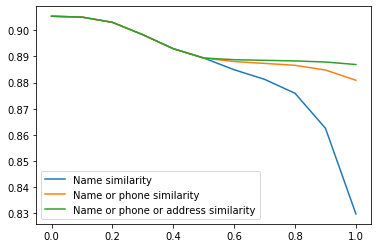

In [25]:
# Plot share of good matches for different thresholds
t = np.linspace(0,1,11)
shares_name = list(map(share_good_matches_name, t))
shares_phone = list(map(lambda x: share_good_matches_phone(x, 0.5), t))
shares_phone_address = list(map(lambda x: share_good_matches_phone_address(x, 0.5, 0.5, 0.8), t))
plt.plot(t, shares_name, label = "Name similarity")
plt.plot(t, shares_phone, label = "Name or phone similarity")
plt.plot(t, shares_phone_address, label = "Name or phone or address similarity")
plt.legend(loc = 'lower left')
plt.show()

In [26]:
# Set the thresholds
threshold_main = 0.8
threshold_phone = 0.5
threshold_address = 0.5
address_similar = 0.8
acceptable_match_phone_address(threshold_main, threshold_phone, threshold_address, address_similar)
matches = best_match('name_phone_address_acceptable')
print(matches.shape[0] / float(unique_restaurants))
# Preview of matches
matches

0.8882790969995323


,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance,name_similarity,address_similarity,name_subset,phone_same,name_acceptable,name_phone_address_acceptable,name_phone_acceptable
0,sg:0000151bf1ed4fe3a39f1b27327821bf,New Ocean Chinese Restaurant,93458,santa maria,ca,331 town center west,+18059251500,Z19kDppC2EAzT3s31mYtIA,New Ocean Chinese Restaurant,+18059251500,93458,331 Town Ctr W,1.616780,1.000000,0.823529,True,True,True,True,True
4,sg:0000342b96c3453fbcd3c80308517f75,Pizza Hut,32348,perry,fl,2199 south byron butler parkway,+18505847480,pYrHAeko8pAwWyxn0Hgltw,Pizza Hut,+18505847480,32347,2199 S Byron Butler Pkwy,3.335255,1.000000,0.872727,True,True,True,True,True
6,sg:00003430f2e24d3d9579db600cdcd4f0,Nacho Bizness,93940,monterey,ca,615 lighthouse avenue,+18315555555,WWtRHUn3SkB5UPPdZubsBg,Nacho Bizness,+18315555555,93940,615 Lighthouse Ave,4.396159,1.000000,0.923077,True,True,True,True,True
26,sg:0000b846c3a14858991896452c6db6be,Popeyes Louisiana Kitchen,29209,columbia,sc,7540 garners ferry road,+18037769633,Znn-iqQfi9AMXbKaA2xdGg,Popeyes Louisiana Kitchen,+18037769633,29209,7540 Garners Ferry Rd,2.464139,1.000000,0.954545,True,True,True,True,True
29,sg:0000cb70fb14407eb09e258033ed2f0b,Pick Up Stix,92029,escondido,ca,1284 auto park way,+17604898533,wABs0V1sTZd4IEzZfWk8GA,Pick Up Stix,+17604898533,92029,1284 Auto Pkwy,13.821985,1.000000,0.875000,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41434,sg:9db93ea664cf432abde1157241a82b24,Zaxby's,34711,clermont,fl,2080 east highway 50,None,6jMLSuBh6fMmsa2Q_z4FDQ,Zaxby's Chicken Fingers & Buffalo Wings,+13525578056,34711,2080 E Hwy 50,127.801777,0.304348,0.787879,True,False,True,True,True
1235112,sg:9612ecdd28b245fe816a6d14e95cdd93,The Broadway Restaurant Catering and Ice Cream,01604,worcester,ma,100 water street,+15085561489,b0DtZ4Rf8Goa8NkmSAmqYg,Broadway,+15087533233,01604,100 Water St,3.391135,0.296296,0.857143,True,False,True,True,True
846779,sg:658bb9365f604751913d6c825e6f77a9,Encore,18229,jim thorpe,pa,66 broadway,+15703254440,GoHVQY2tdaK8Oc1PthIXrQ,Tony Stella's Encore Fine Food & Spirits,+15707324600,18229,66 Broadway,42.100113,0.260870,1.000000,True,False,True,True,True
1594468,sg:c3d275ecedcf474dbf0f340ddf041a5b,Cafe,79001,adrian,tx,300 east historic route 66,+18065360038,limQpxSdDasr3PBzRU66aw,Midpoint Cafe and Gift Shop,+18065386379,79001,305 W Historic Rt 66,3.153619,0.258065,0.782609,True,False,True,True,True


In [28]:
# Check how many SG restaurants are matched to the same Yelp restaurant
print(matches.shape[0])
print(matches.sname_place_id.nunique())
print(matches.y_id.nunique())
assert matches.shape[0] == matches.sname_place_id.nunique() == matches.y_id.nunique()

527970
527970
527970


In [32]:
# Preview of non-matches:
non_matches_similarity = ((match_candidates['name_similarity'] >= 0.45) &
                          (match_candidates['name_similarity'] <= 0.5))
non_matches_test = match_candidates.loc[non_matches_similarity
                                       ].merge(matches, 
                                               how = 'left', 
                                               indicator = True
                                              )
non_matches_test = non_matches_test.loc[non_matches_test['_merge'] == 'left_only']
non_matches_test

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,...,y_address1,distance,name_similarity,address_similarity,name_subset,phone_same,name_acceptable,name_phone_address_acceptable,name_phone_acceptable,_merge
0,sg:00001b8625b64052888b8c2f2e3736bb,Golden Corral,32819,orlando,fl,8032 international drive,+14073526606,TXLHsexRp-ijxlnL5bu_ig,Cold Stone Creamery,+14072242295,...,1000 Universal Studios Plaza,68.635658,0.500000,0.384615,False,False,False,False,False,left_only
1,sg:00003430f2e24d3d9579db600cdcd4f0,Nacho Bizness,93940,monterey,ca,615 lighthouse avenue,+18315555555,nwsqQe8aHShRw8QfoEdhTw,Nancy Dean’s,+18319201940,...,598 Lighthouse Ave,62.581096,0.480000,0.820513,False,False,False,False,False,left_only
3,sg:000216bd21424e97a8024349feceae0a,The Cheese Lodge,34652,new port richey,fl,4134 grand boulevard,+17278486651,-e6JPq8mFkMQQoWyANSgrQ,The Fish Guy,+17272648818,...,4114 Grand Blvd,74.614250,0.500000,0.800000,False,False,False,True,False,left_only
5,sg:0003c3aef6c04ec89795cb982d6095a7,Ruth's Chris Steak House,39530,biloxi,ms,777 beach boulevard,+12283742137,mWjNmoKYNoVx6DNnjKk4GQ,Rise Lounge,+12283747625,...,777 Beach Blvd,99.269054,0.457143,0.848485,False,False,False,False,False,left_only
6,sg:000470b91aa749dd9a616e1ed80f99fa,Rosa's Cafe,78665,round rock,tx,2111 east palm valley boulevard,None,MTI0hrkTqtTC1nIdcAlZ5Q,Rosa's Café & Tortilla Factory,+15125374999,...,2111 E Palm Valley Blvd,36.873478,0.487805,0.851852,False,False,False,False,False,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53893,sg:fe53b7d5efa0416394f074adde798f41,Capital Cafe,20001,washington,dc,101 constitution avenue north west,None,14whDsYM570e_JCGN2aP4Q,West Wing Cafe,+12023475855,...,300 New Jersey Ave NW,266.179254,0.461538,0.400000,False,False,False,False,False,left_only
53894,sg:fee4d6e9225c48719ff663c195bbdfbb,Pizza Hut,17602,lancaster,pa,2395 lincoln highway east,None,ldBLlAWrCWv_SCBXBCKjuQ,CiCis Pizza,+17179457695,...,2405 Covered Bridge Dr,115.745245,0.500000,0.382979,False,False,False,False,False,left_only
53895,sg:ff63893ab09e40e690455fc2e9f1cdd3,Mulligan's Restaurant At Stratton Mountain,05155,stratton,vt,11 b village square,None,ylxXXvUWgRM-bfGH2ZYDuA,Grizzly's At Stratton,+18022974371,...,10 Base Lodge Rd,128.735469,0.476190,0.514286,False,False,False,False,False,left_only
53896,sg:ff63893ab09e40e690455fc2e9f1cdd3,Mulligan's Restaurant At Stratton Mountain,05155,stratton,vt,11 b village square,None,hWkob43rc5CbLfbOz8H9Gw,Mulligan's Taverne,+18022979293,...,Stratton Mountain Rd,143.719726,0.500000,0.256410,False,False,False,False,False,left_only


In [37]:
# Preview of marginal matches
matches.sort_values(['name_similarity', 'distance'],
                    ascending = [True, False]
                   ).iloc[5040:5060]

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance,name_similarity,address_similarity,name_subset,phone_same,name_acceptable,name_phone_address_acceptable,name_phone_acceptable
681343,sg:512a2166b412472282e412853b06de84,Subway,73135,oklahoma city,ok,7727 south sunnylane road,None,J2uApRcGxmkznxAGaeJeMg,Subway Restaurants,+14056728766,73135,7727 S Sunnylane Rd,68.825457,0.5,0.863636,True,False,True,True,True
971184,sg:74e14488756440219b5930f028bef5ed,Subway,60418,crestwood,il,13158 south cicero avenue,+17083968800,Y-jUtb-7TJ8ZQMrQFtfOgQ,Subway Restaurants,+17083968800,60445,13158 S Cicero Ave,68.787255,0.5,0.837209,True,True,True,True,True
1875371,sg:e82094c9c9b84198b34322eeaa8fc7d2,Subway,20678,prince frederick,md,55 solomons island road north,None,gzmgKky2M-KyTyp9sFxaTw,Subway Restaurants,+14105351988,20678,55 Solomons Island Rd N,68.779933,0.5,0.884615,True,False,True,True,True
618123,sg:495c8573dc4f4463a53372f34f0f682c,Subway,17340,littlestown,pa,410 west king street,+17173594411,Wu0eB0xpcU7VI9-OhO0uow,Subway Restaurants,+17173594411,17340,410 W King St,68.772122,0.5,0.787879,True,True,True,True,True
385742,sg:2d5a3909d9d34c279a705ba3320fadeb,Subway,28152,shelby,nc,705 east dixon boulevard,None,T0sadKlruy8Qt0kXVv5rmw,Subway Restaurants,+17044875603,28152,705 E Dixon Boulevard,68.766175,0.5,0.933333,True,False,True,True,True
1626941,sg:c7fd4ec181c6434aa66378f9aca76d0f,Subway,56482,wadena,mn,981 jefferson street north,+12186317151,6En_pWh6eNBRfpStvfwh2A,Subway Restaurants,+12186317151,56482,981 Jefferson St N,68.726732,0.5,0.818182,True,True,True,True,True
1495628,sg:b75a02c3ff7d4e80ab6d544ccd04657b,Subway,77665,winnie,tx,45950 ih 10,None,NyqRq6sFdgVYBkc6J-BsRg,Subway Restaurants,+14092962183,77665,45950 IH-10,68.722236,0.5,0.869565,True,False,True,True,True
1134908,sg:896c477091184b4998b4e4c8dc0f61b2,Subway,57301,mitchell,sd,1101 east spruce street,+16059961019,ZtuL4XChcmZAgQfEflZ5hQ,Subway Restaurants,+16059961019,57301,1101 E Spruce St,68.692310,0.5,0.820513,True,True,True,True,True
2002540,sg:f87cacac1f594699afb2760ed2bf79ee,Subway,74804,shawnee,ok,4439 north kickapoo,+14052739892,1NWdL2waappJRBN2Xvy5Rw,Subway Restaurants,+14052739892,74804,4439 N Kickapoo,68.658686,0.5,0.882353,True,True,True,True,True
55420,sg:066bcdd90dcf4ac7985e304f8bdb62a7,Subway,60538,montgomery,il,2000 orchard road,+16302648384,nnS3u0p3uHPopYyFZ-i_xg,Subway Restaurants,+16302648384,60538,2000 Orchard Road,68.648792,0.5,1.000000,True,True,True,True,True


In [40]:
# Preview of marginal matches
matches.sort_values(['distance', 'name_similarity'],
                    ascending = [False, True]
                   ).iloc[140:160]

,sname_place_id,r_location_name,r_zip_code,r_city,r_state,r_street_address,r_phone_number,y_id,y_name,y_phone,y_zip_code,y_address1,distance,name_similarity,address_similarity,name_subset,phone_same,name_acceptable,name_phone_address_acceptable,name_phone_acceptable
163850,sg:8847072e854948d7b4e1aba133bf03c0,Gyro Palace,45431,dayton,oh,4884 airway road,+19372543895,omKyyrB_pGcUKZNED3KCdg,Gyro Palace,+19372543895,45431,4884 Airway Rd,296.613841,1.000000,0.933333,True,True,True,True,True
284852,sg:f1e3d7d9e5784bf08063836f5f995944,Subway,85741,tucson,az,7635 north la cholla boulevard,+15205442234,ZmB5HzwjhV12ALvuvDwkLg,Subway Restaurants,+15205442234,85741,7635 N La Cholla Blvd,296.546293,0.500000,0.823529,True,True,True,True,True
183659,sg:9928d7bdc7ce4d9b9ccc24f8463f476e,Gigi's Cafe,33027,pembroke pines,fl,701 south west flamingo west drive,+19543918003,YJxIFPwYDzpN4i-q_awYBg,Gigi's Cafe,+19543918003,33027,701 SW Flamingo W Dr,296.492705,1.000000,0.740741,True,True,True,True,True
241298,sg:cb6c7c958f3d49ccaa3c681c1ec32e1d,Firebirds Wood Fired Grill,16066,cranberry twp,pa,7300 cranberry springs dr cranberry,+17248315450,zfkec0WB0i8CWjC3UvUGzA,Firebirds Wood Fired Grill,+17248315450,16066,7300 Cranberry Springs Dr,296.448519,1.000000,0.833333,True,True,True,True,True
217532,sg:b699fccfb9ee45febbec41b4b0ea29ea,First Wok,06082,enfield,ct,136 elm street,+18602539600,xgY7eOex_DmzYn3qPGe1JQ,First Wok,+18602539600,06082,136 Elm St,296.328379,1.000000,0.833333,True,True,True,True,True
31230,sg:74f928450cfe4601806001f5cb09c8a5,O'Brien's Restaurant & Bar,49117,new buffalo,mi,12578 wilson road whittaker woods golf community,None,ejLZCtHo-notTuT-C3dCZw,O'Brien's Restaurant & Bar,+12694693400,49117,12578 Wilson Rd,296.313538,1.000000,0.476190,True,False,True,True,True
19718,sg:47fe261757f94c0aa6fb5145d7a2dc7e,Murray Parkway Cafe,84123,salt lake city,ut,6345 murray parkway avenue,+18012686611,2L2hsn0YA4ve8OHSnMJdlg,Murray Parkway Golf Course,+18012624653,84123,6345 Murray Parkway Ave,296.298719,0.755556,0.938776,False,False,False,True,False
101846,sg:53a4b53140b8405d976cd8c365e3b6b7,Moose Junction,59602,helena,mt,7534 roughsawn drive,+14064581936,vIinyBgmww2nwGWmiVY_ew,Moose Junction,+14064581936,59602,7534 Roughsawn Dr,296.291873,1.000000,0.918919,True,True,True,True,True
94327,sg:4d4d541dc1c24864b8063791b46b1629,Jersey Mike's,07876,succasunna,nj,275 state route 10 east,+18624199900,gNmtExZ1Q912VjOPPNYNTw,Jersey Mike's Subs,+18624199900,07876,275 State Route 10 E,296.289153,0.838710,0.930233,True,True,True,True,True
254039,sg:d685f02d46ea4485a4c9fdf3ddb09d95,Dairy Queen,59601,helena,mt,1700 prospect avenue,+14064425265,y7bJ_aoW9j-um6zG4o1Qwg,Dairy Queen,+14064425265,59601,1500 Prospect Ave,296.271808,1.000000,0.864865,True,True,True,True,True


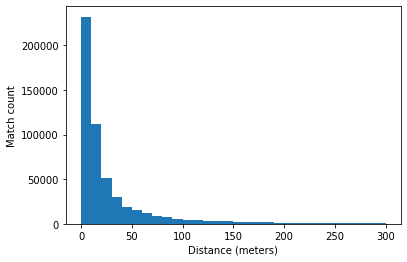

In [44]:
# Preview of the distance between matched entities
ds = matches.distance
plt.hist(ds, bins = 30)
plt.xlabel('Distance (meters)')
plt.ylabel('Match count')
plt.show()

In [45]:
# Export matching to PostgreSQL adding a primary key
restaurants_table = matches[['sname_place_id',
                             'y_id'
                            ]
                           ]
restaurants_table.reset_index(drop = True, inplace = True)
restaurants_table.to_sql('sg_yelp_matching', 
                         con = engine, 
                         index = False
                        )
connection.execute('ALTER TABLE sg_yelp_matching ADD PRIMARY KEY (sname_place_id);')

In [46]:
engine.dispose()